# Classification Modeling - Update

# Imports

In [1]:
from joblib import parallel_backend
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Import modeling tools, pipelines, models, and metrics

## Import modeling tools, pipelines, models, and metrics

from sklearnex import patch_sklearn
patch_sklearn()

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers import Winsorizer

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

import shap

from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, StandardScaler

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import tensorflow as tf

set_config(transform_output='pandas')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Select Features

In [2]:
filepath = '../../data/column_groups.json'
with open(filepath, 'r') as file:
    data = json.load(file)
    
for k, v in data.items():
    print(k, v)

booking_details ['UUID', 'HotelNumber', 'Adults', 'Children', 'Babies', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType', 'ADR']
post_stay_details ['UUID', 'AssignedRoomType', 'BookingChanges', 'DaysInWaitingList', 'RequiredCarParkingSpaces', 'ReservationStatus']
reservation_specific ['UUID', 'Meal', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled']
temporal_features ['UUID', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights', 'ReservationStatusDate']
new_temporal_features ['ADR_30d_avg', 'ADR_30d_std', 'ADR_7d_avg', 'ADR_7d_std', 'ADR_ewm_3', 'ADR_ewm_7', 'ADR_lag_1', 'ADR_lag_7', 'ArrivalDateDayName', 'ArrivalDateMonthName', 'ArrivalDate_DaysAfterHoliday', 'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'BookingDate_DaysAfterHoliday', 'BookingDate_DaysBeforeHoliday', 'DaysSinceBooki

In [3]:
selected_features = data['booking_details']
selected_features.extend(data['post_stay_details'])
selected_features.extend(data['new_temporal_features'])
selected_features = set(selected_features)
selected_features.remove('UUID')
selected_features.remove('ADR')
selected_features = list(selected_features)
selected_features.sort()

In [4]:
selected_features

['ADR_30d_avg',
 'ADR_30d_std',
 'ADR_7d_avg',
 'ADR_7d_std',
 'ADR_ewm_3',
 'ADR_ewm_7',
 'ADR_lag_1',
 'ADR_lag_7',
 'Adults',
 'Agent',
 'ArrivalDateDayName',
 'ArrivalDateMonthName',
 'ArrivalDate_DaysAfterHoliday',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDay',
 'ArrivalWeek',
 'AssignedRoomType',
 'Babies',
 'BookingChanges',
 'BookingDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'Children',
 'Company',
 'Country',
 'CustomerType',
 'DaysInWaitingList',
 'DaysSinceBooking',
 'DepartureDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepositType',
 'DistributionChannel',
 'HotelNumber',
 'Length of Stay',
 'MarketSegment',
 'RequiredCarParkingSpaces',
 'ReservationStatus',
 'ReservedRoomType']

# Load Data

In [5]:
df_data = pd.read_feather('../../data/2.3_data_with_occupancies.feather', columns=selected_features)
df_data

,Adults,Children,Babies,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,...,ArrivalDateDayName,ArrivalDateMonthName,ADR_lag_1,ADR_lag_7,ADR_7d_avg,ADR_30d_avg,ADR_7d_std,ADR_30d_std,ADR_ewm_3,ADR_ewm_7
0,2,0.0,0,PRT,Direct,Direct,C,C,3,No Deposit,...,Wednesday,July,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.0,0,IRL,Offline TA/TO,TA/TO,A,A,0,No Deposit,...,Wednesday,July,76.50,101.5,82.00,87.43,17.41,16.89,83.17,86.84
2,2,0.0,0,IRL,Offline TA/TO,TA/TO,A,A,0,No Deposit,...,Wednesday,July,69.60,76.5,82.53,82.87,16.78,16.76,76.39,82.53
3,2,0.0,0,GBR,Offline TA/TO,TA/TO,A,A,0,No Deposit,...,Wednesday,July,55.68,111.5,67.26,79.90,10.61,19.67,66.03,75.82
4,3,0.0,0,ESP,Offline TA/TO,TA/TO,A,C,2,No Deposit,...,Wednesday,July,82.35,76.5,69.21,75.73,13.34,14.19,74.19,77.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,2,0.0,0,FRA,Online TA,TA/TO,A,A,0,No Deposit,...,Thursday,August,162.00,72.2,127.00,114.50,30.31,26.63,136.18,130.86
119386,2,0.0,0,GBR,Online TA,TA/TO,A,A,0,No Deposit,...,Thursday,August,187.00,109.5,134.11,130.86,49.18,33.55,152.92,138.32
119387,2,0.0,0,GBR,Online TA,TA/TO,D,F,4,No Deposit,...,Thursday,August,127.58,187.0,171.53,181.15,39.00,60.50,165.02,170.90
119388,2,0.0,0,GBR,Online TA,TA/TO,A,A,0,No Deposit,...,Thursday,August,207.50,207.0,194.12,183.64,17.74,39.95,192.83,184.29


In [6]:
df_data[selected_features]

,ADR_30d_avg,ADR_30d_std,ADR_7d_avg,ADR_7d_std,ADR_ewm_3,ADR_ewm_7,ADR_lag_1,ADR_lag_7,Adults,Agent,...,DepartureDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepositType,DistributionChannel,HotelNumber,Length of Stay,MarketSegment,RequiredCarParkingSpaces,ReservationStatus,ReservedRoomType
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NULL,...,21,45,No Deposit,Direct,H1,0,Direct,0,Check-Out,C
1,87.43,16.89,82.00,17.41,83.17,86.84,76.50,101.5,2,156,...,28,38,No Deposit,TA/TO,H1,7,Offline TA/TO,0,Check-Out,A
2,82.87,16.76,82.53,16.78,76.39,82.53,69.60,76.5,2,156,...,28,38,No Deposit,TA/TO,H1,7,Offline TA/TO,0,Check-Out,A
3,79.90,19.67,67.26,10.61,66.03,75.82,55.68,111.5,2,115,...,28,38,No Deposit,TA/TO,H1,7,Offline TA/TO,0,Check-Out,A
4,75.73,14.19,69.21,13.34,74.19,77.45,82.35,76.5,3,6,...,26,40,No Deposit,TA/TO,H1,5,Offline TA/TO,1,Check-Out,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,114.50,26.63,127.00,30.31,136.18,130.86,162.00,72.2,2,9,...,19,32,No Deposit,TA/TO,H2,3,Online TA,0,Check-Out,A
119386,130.86,33.55,134.11,49.18,152.92,138.32,187.00,109.5,2,9,...,18,33,No Deposit,TA/TO,H2,2,Online TA,0,Check-Out,A
119387,181.15,60.50,171.53,39.00,165.02,170.90,127.58,187.0,2,9,...,18,33,No Deposit,TA/TO,H2,2,Online TA,0,Check-Out,D
119388,183.64,39.95,194.12,17.74,192.83,184.29,207.50,207.0,2,89,...,23,28,No Deposit,TA/TO,H2,7,Online TA,0,Check-Out,A


## Transform Target

In [7]:
df_data.loc[:, 'ReservationStatus'] = np.where(df_data['ReservationStatus'] == 'No-Show', 'Canceled', df_data['ReservationStatus'])
df_data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

# Train/Test Split

In [8]:
target_feature = 'ReservationStatus'

X = df_data.loc[:, selected_features].drop(columns=target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 903, stratify=y)

In [9]:
y_train.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

In [10]:
y_test.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

# Model - Without Tuning

In [33]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
#                          ('encoder', CountFrequencyEncoder(unseen = 'encode',
#                                                            encoding_method = 'frequency',
#                                                            missing_values='ignore'))])

# Update the categorical pipeline to use OneHotEncoder
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',
                              sparse_output=False,
                              max_categories=5))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    # ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
    # ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    # ('scaler', StandardScaler())
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 Index(['ADR_30d_avg', 'ADR_30d_std', 'ADR_7d_avg', 'ADR_7d_std', 'ADR_ewm_3',
       'ADR_ewm_7', 'ADR_lag_1', 'ADR_lag_7', 'Adults',
       'ArrivalDate_DaysAfterHoliday', 'ArrivalDate_DaysBeforeHoliday',
       'ArrivalDay', 'ArrivalWeek', 'Babies', 'BookingChanges',
       'BookingDate_DaysAfterHoliday',...
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                max_categories=5,
                                                                sparse_output=False))]),
                                 Index(['Agent', 'AssignedRoomType', 'Company', 'Country', 'CustomerType',
       'DepositType', 'DistributionChannel', 'HotelNumber', 'MarketSegment',
       'ReservedRoomType'],
      dtype='object'))])

In [34]:
X_train_xf = preprocessor.fit_transform(X_train)
X_train_xf

,num__ADR_30d_avg,num__ADR_30d_std,num__ADR_7d_avg,num__ADR_7d_std,num__ADR_ewm_3,num__ADR_ewm_7,num__ADR_lag_1,num__ADR_lag_7,num__Adults,num__ArrivalDate_DaysAfterHoliday,...,cat__MarketSegment_Direct,cat__MarketSegment_Groups,cat__MarketSegment_Offline TA/TO,cat__MarketSegment_Online TA,cat__MarketSegment_infrequent_sklearn,cat__ReservedRoomType_A,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_infrequent_sklearn
22630,61.97,55.33,80.77,44.63,68.73,72.83,55.00,2.00,1.0,4.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27839,55.77,26.62,71.63,33.24,79.32,63.43,99.88,38.50,1.0,24.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
57614,87.29,10.29,92.00,10.39,88.27,85.73,86.00,69.00,1.0,61.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
89102,95.15,36.28,111.53,51.64,107.07,98.46,93.60,103.87,2.0,25.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60874,77.74,11.33,78.50,3.12,79.67,76.58,81.00,56.00,1.0,9.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67389,103.01,13.48,107.76,17.51,108.47,105.06,108.29,108.16,2.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
32894,124.74,20.43,128.28,2.10,127.03,127.28,130.50,131.00,2.0,4.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
82794,117.94,86.83,153.40,92.55,171.47,130.75,221.40,80.75,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
102869,115.86,46.60,99.25,0.00,101.55,109.35,99.25,135.00,2.0,5.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [35]:
for col in X_train_xf.columns:
    print(col)

num__ADR_30d_avg
num__ADR_30d_std
num__ADR_7d_avg
num__ADR_7d_std
num__ADR_ewm_3
num__ADR_ewm_7
num__ADR_lag_1
num__ADR_lag_7
num__Adults
num__ArrivalDate_DaysAfterHoliday
num__ArrivalDate_DaysBeforeHoliday
num__ArrivalDay
num__ArrivalWeek
num__Babies
num__BookingChanges
num__BookingDate_DaysAfterHoliday
num__BookingDate_DaysBeforeHoliday
num__Children
num__DaysInWaitingList
num__DaysSinceBooking
num__DepartureDate_DaysAfterHoliday
num__DepartureDate_DaysBeforeHoliday
num__Length of Stay
num__RequiredCarParkingSpaces
cat__Agent_          1
cat__Agent_          9
cat__Agent_        240
cat__Agent_       NULL
cat__Agent_infrequent_sklearn
cat__AssignedRoomType_A               
cat__AssignedRoomType_D               
cat__AssignedRoomType_E               
cat__AssignedRoomType_F               
cat__AssignedRoomType_infrequent_sklearn
cat__Company_         40
cat__Company_         67
cat__Company_        223
cat__Company_       NULL
cat__Company_infrequent_sklearn
cat__Country_ESP
cat__Coun

In [36]:

## --- Build the full pipeline --- ##
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced'))])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):

    ## --- Fit the model and generate predictions --- ##
    model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

## --- Evaluate performance metrics --- ##
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

## Model Results

### Scoring


Training Score: 1.000
Testing Score: 0.900
Difference: 0.100

              precision    recall  f1-score   support

    Canceled       0.93      0.79      0.85     11056
   Check-Out       0.89      0.96      0.92     18792

    accuracy                           0.90     29848
   macro avg       0.91      0.88      0.89     29848
weighted avg       0.90      0.90      0.90     29848



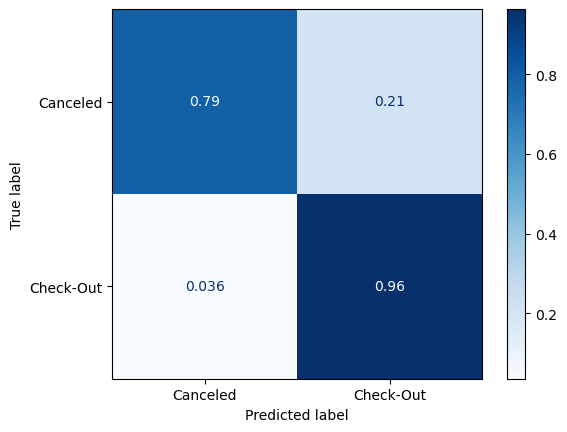

In [37]:
print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

### Permutation Importances

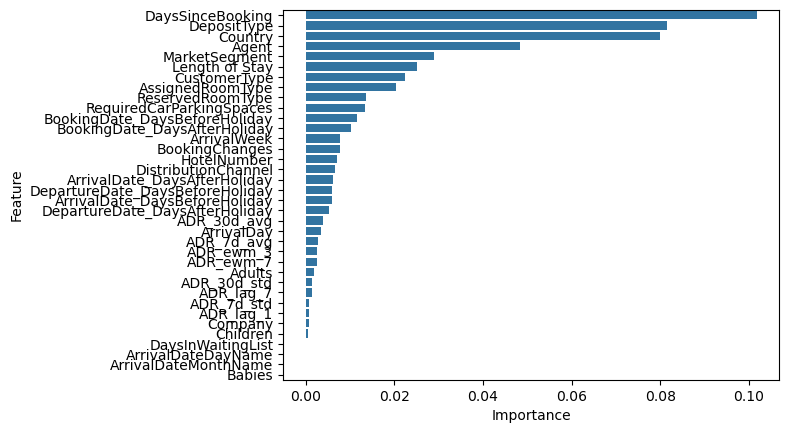

In [38]:
# Calculate permutation importances
result = permutation_importance(model_pipeline,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

### Tree Depths

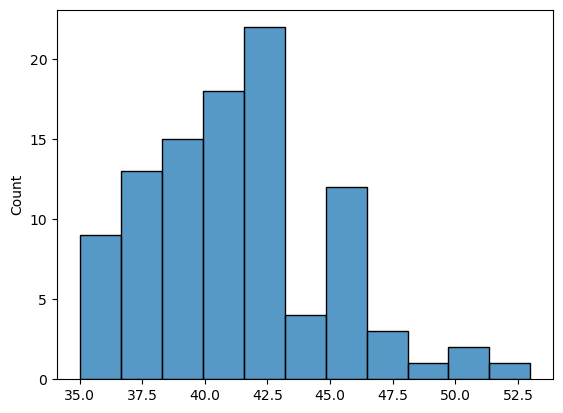

In [22]:
depths = [tree.get_depth() for tree in model_pipeline[-1].estimators_]

sns.histplot(depths);

# Model - With Tuning

In [25]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
#                          ('encoder', CountFrequencyEncoder(unseen = 'encode',
#                                                            encoding_method = 'frequency',
#                                                            missing_values='ignore'))])

# Update the categorical pipeline to use OneHotEncoder
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',
                              sparse_output=False,
                              drop='first',
                              max_categories=5))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])


# Create the RandomForestClassifier model
classifier = RandomForestClassifier(class_weight='balanced',
                                    max_depth= 15,
                                    min_samples_split= 2,
                                    min_samples_leaf= 2)

# Build the full imbalanced-learn pipeline with SMOTETomek
# model_pipeline = ImbPipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('smote_tomek', SMOTETomek()),
#     ('classifier', classifier)
# ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Set up hyperparameter tuning with HalvingGridSearchCV
param_grid = {
    'classifier__max_depth': [15,20],
    'classifier__min_samples_split': [2, 4, 10],
    'classifier__min_samples_leaf': [2, 4]
}

# Set up Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=False)

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    grid_search = HalvingGridSearchCV(model_pipeline,
                               param_grid,
                               scoring='f1',
                               cv=stratified_kfold)

    # Fit the model and generate predictions
    grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate performance metrics
score_training = best_model.score(X_train, y_train)
score_testing = best_model.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.2f}\n'
      f'Testing Score: {score_testing:,.2f}\n'
      f'Difference: {score_training - score_testing:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 


Training Score: 0.98
Testing Score: 0.91
Difference: 0.08



## Model Results

### Scoring

              precision    recall  f1-score   support

    Canceled       0.95      0.79      0.86     11056
   Check-Out       0.89      0.98      0.93     18792

    accuracy                           0.91     29848
   macro avg       0.92      0.88      0.90     29848
weighted avg       0.91      0.91      0.90     29848



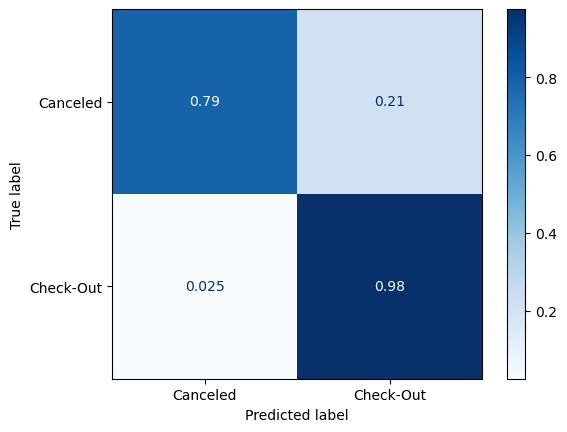

In [29]:
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

In [30]:
metrics.f1_score(y_test, y_pred, average='weighted').round(2)

0.9

### Permutation Importances

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


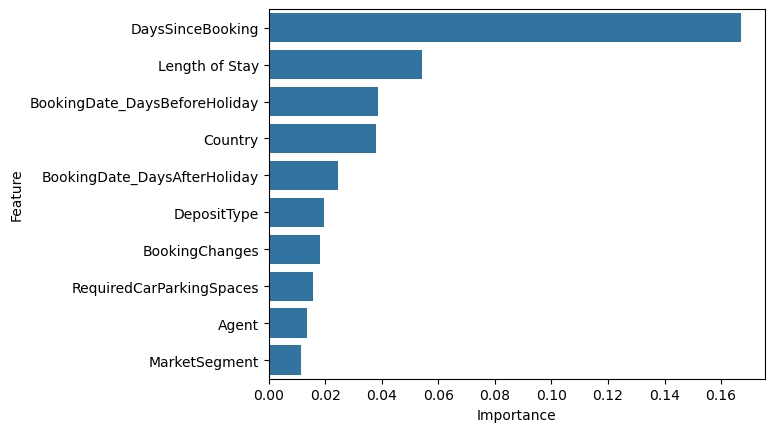

In [32]:
# Calculate permutation importances
result = permutation_importance(best_model,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

# SHAP

In [50]:
X_train_xf = best_model.named_steps.preprocessor.fit_transform(X_train)
X_train_xf

,num__ADR_30d_avg,num__ADR_30d_std,num__ADR_7d_avg,num__ADR_7d_std,num__ADR_ewm_3,num__ADR_ewm_7,num__ADR_lag_1,num__ADR_lag_7,num__Adults,num__ArrivalDate_DaysAfterHoliday,...,cat__MarketSegment_Undefined,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_P,cat__ReservedRoomType_infrequent_sklearn
22630,-1.169260,1.325481,-0.553435,0.767539,-0.877929,-0.855859,-0.990167,-2.116507,-1.751264,-1.017047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27839,-1.351927,-0.276696,-0.795794,0.260827,-0.595425,-1.134892,-0.035696,-1.340842,-1.751264,-0.263211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57614,-0.423273,-1.188000,-0.255656,-0.755710,-0.356670,-0.472929,-0.330885,-0.692684,-1.751264,1.131385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89102,-0.191698,0.262386,0.262207,1.079396,0.144848,-0.095046,-0.169254,0.048342,0.302471,-0.225519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60874,-0.704638,-1.129962,-0.613627,-1.079133,-0.586088,-0.744542,-0.437220,-0.968948,-1.751264,-0.828588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67389,0.039876,-1.009980,0.162241,-0.438960,0.182195,0.100871,0.143161,0.139509,0.302471,-1.054739,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
32894,0.680093,-0.622132,0.706355,-1.124510,0.677311,0.760460,0.615504,0.624884,0.302471,-1.017047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82794,0.479749,3.083356,1.372445,2.899375,1.862815,0.863465,2.548690,-0.442984,0.302471,-1.130122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102869,0.418467,0.838299,-0.063413,-1.217934,-0.002406,0.228218,-0.049095,0.709888,0.302471,-0.979355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
X_shap = shap.sample(X_train_xf, 500)
X_shap

,num__ADR_30d_avg,num__ADR_30d_std,num__ADR_7d_avg,num__ADR_7d_std,num__ADR_ewm_3,num__ADR_ewm_7,num__ADR_lag_1,num__ADR_lag_7,num__Adults,num__ArrivalDate_DaysAfterHoliday,...,cat__MarketSegment_Undefined,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_P,cat__ReservedRoomType_infrequent_sklearn
36397,0.383702,0.208254,0.181863,0.406746,0.202469,0.424729,-0.124593,0.178611,0.302471,-0.640129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118080,0.870420,0.101666,1.252326,0.529531,0.830434,1.005950,0.343710,-0.456797,0.302471,-1.054739,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
103848,0.934943,1.125140,1.715301,1.692432,1.277266,1.228584,0.285863,0.476126,0.302471,-1.054739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44239,-0.060002,0.626796,-0.907692,-0.504356,-0.590356,-0.251780,-0.529307,1.092408,-1.751264,-0.413978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17955,0.208695,0.040838,0.592865,0.682568,0.634362,0.528921,0.370932,-0.777688,0.302471,0.000632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24281,-0.704049,-0.355381,-0.435967,-0.778843,-0.362539,-0.631741,-0.226675,-0.565177,0.302471,-1.092430,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20023,3.101524,0.105014,3.167886,0.061079,3.168348,3.103926,3.280609,3.132513,0.302471,-1.017047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93084,-0.615073,-0.650035,-0.382670,-0.316619,-0.261168,-0.442057,0.141247,-0.883944,-1.751264,-0.602437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88996,-1.303019,-0.960872,-1.316309,-1.217934,-1.302085,-1.305578,-1.053968,-1.053953,0.302471,-0.263211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
y_shap = y_train.loc[X_shap.index]
y_shap

36397     Check-Out
118080     Canceled
103848    Check-Out
44239     Check-Out
17955      Canceled
            ...    
24281     Check-Out
20023      Canceled
93084     Check-Out
88996      Canceled
73094     Check-Out
Name: ReservationStatus, Length: 500, dtype: object

In [53]:
explainer = shap.Explainer(best_model.named_steps.classifier, X_shap)
shap_values = explainer(X_shap)
shap_values.shape

100%|===================| 997/1000 [00:54<00:00]        

(500, 386, 2)

## Summary Plot

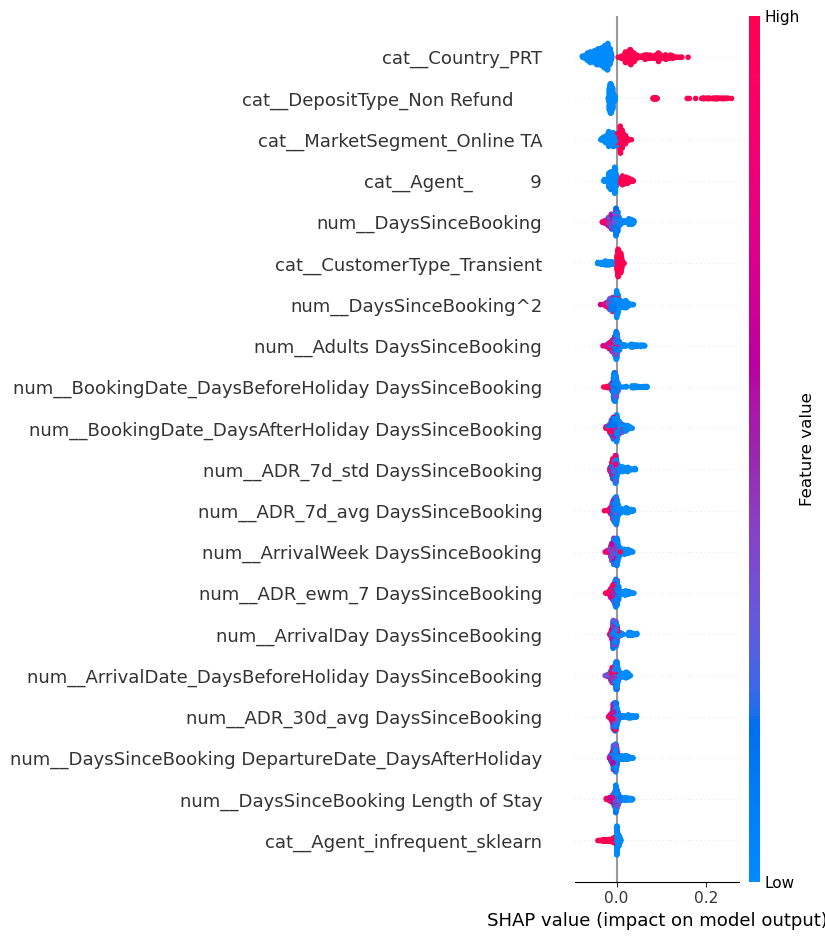

In [63]:
shap.summary_plot(shap_values[:, :, 0], X_shap)

In [62]:
df_data.groupby(['Country'])[['ReservationStatus']].value_counts(normalize=True).loc['PRT']

ReservationStatus
Canceled     0.566351
Check-Out    0.433649
Name: proportion, dtype: float64

## Force Plot

In [ ]:
# For multiple predictions
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)